

# Personalized Contrastive Learning in Dysarthric Word Recognition

## Build Train + Holdouts, Triplets

This notebook is meant to contain the code used in James Dana's final project for the classs DATA-0297 in Spring 2025.


## Getting TORGO

I obtained the TORGO dataset via a HuggingFace implementation, "abnerh/TORGO-database". I then filtered out all columns I didnt need, and stored the result in a parquet file on Colab.

Goal: Using the TORGO dataset downloaded earlier, split into train, holdout-gen, holdout-per, and then store.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [2]:
# import the modules we'll need

# modules for handling data
from datasets import load_dataset, Dataset
from google.colab import drive
import pandas as pd
import numpy as np
import random

# modules for visuals
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the TORGO dataset

I've already moved the data I need to Google Drive. I'll load it now.

In [3]:
# mount drive.
drive.mount('/content/drive')

# Load the parquet with only the nested metadata...
df = pd.read_parquet("/content/drive/MyDrive/torgo_data/torgo_subset.parquet", columns=["audio.path", "speech_status", "gender", "duration", "transcription"])
df.head()

Mounted at /content/drive


,path,speech_status,gender,duration,transcription
0,FC01_1_arrayMic_0066.wav,healthy,female,3.30,alpha
1,FC01_1_arrayMic_0016.wav,healthy,female,3.45,the
2,FC01_1_arrayMic_0061.wav,healthy,female,7.20,Except in the winter when the ooze or snow or ...
3,FC01_1_arrayMic_0053.wav,healthy,female,3.60,raid
4,FC01_1_arrayMic_0043.wav,healthy,female,3.45,read


In [4]:
df.shape

(16552, 5)

The 'path' value actually gives us some really useful information to work with. Let's transform the data to get some good IDs.

In [ ]:
# Define Speaker ID (ie "M01", "FC01") from path.
df['speaker_id'] = df['path'].str.split('_').str[0]

# Clean transcription just in case.
df['transcription'] = df['transcription'].str.lower().str.strip()

# find an id that cleanly maps to a transcription
# FC01_1_arrayMic_0066.wav => Speaker: FC01, Mic: arrayMic id: 1_0066.
df['misc_id_1'] = df['path'].str.split('_').str[1]
df['misc_id_3'] = df['path'].str.split('_').str[3].str.split('.').str[0]
df['speech_id'] = df['misc_id_1'] + '_' + df['misc_id_3']

# check that there's only one transcription per speech_id
print(df[['speaker_id','speech_id','transcription']].drop_duplicates().groupby(['speaker_id','speech_id']).size().reset_index(name='count').sort_values('count').max())

speaker_id      MC04
speech_id     3_1000
count              1
dtype: object


In [ ]:
# whats the average number of files per speech event?
df_filecount = df.groupby(['speaker_id','speech_id','transcription']).size().reset_index(name='count')
print(df_filecount['count'].mean())
print(df_filecount['count'].median())
print(df_filecount['count'].max())

1.8239118457300276
2.0
2


## Personalization versus Generalizability

The goal of this project is to think about the complex tradeoffs that a solution for this population (people with speech disorders) must think about. For example:

- Suppose we can provide a model with example speech of a given person with a speech disorder. Can this model be personalized? Will it be able to handle new speech audio by that user?
- Suppose we can train a model with example speech of a body of people with speech disorders. Can this model be generalizable? Will it be able to handle new users, or it is limited to to the trained users?

Given this, we want to determine a holdout set for evaluating this model and this approach that can attempt to answer both concerns. Given this, we are going to do two different things:

- Select some participants in the TORGO dataset to exclude from training, and evaluate how the TORGO dataset handles those participants' data. This will help address the 'generalizability' concern.
- Select a subset of audio files of the participants we don't exclude, and examine how those audio files are handled by the trained model. This will help address the 'personalization' concern.

In order to do this effectively, we first need to establish the words we'll classify in the model, which we will now think more about.

## Contrastive Learning

Contrastive learning is a machine learning framework that encourages a model to learn representations of data (images, audio, et cetera) by contrasting similar and dissimilar examples. The idea is to **pull together** similar instances and **push apart** dissimilar ones, which helps the model learn meaningful features that can generalize well to new, unseen data. This is commonly done using a loss function that minimizes the distance between similar samples (positive pairs) and maximizes the distance between dissimilar samples (negative pairs).

For **speech processing**, contrastive learning helps the model to:

- Learn speaker-invariant representations
- Understand how to generalize across speakers, acoustic conditions, or speech disorders

## Triplets in Contrastive Learning

There are multiple ways to do contrastive learning, but one method is to use a **triplet structure**. A **triplet** is a structured set of three samples:

- **Anchor**: A sample.
- **Positive**: A sample similar to the anchor (same class or condition)
- **Negative** A sample dissimilar to the anchor (different class or condition)

The model is trained to minimize the distance between the anchor and the positive, and maximize the distance between the anchor and the negative. This helps the model learn better feature representations by learning to distinguish between similar and dissimilar examples.

In speech processing, the triplets typically consist of audio recordings that share or differ based on factors like:

- Speaker (same or different)

- Word (same or different)

- Speech status (e.g., healthy or dysarthric)

## Triplet Type Framework: Balancing Personalization and Generalization

To strike the right balance between generalization (learning from different speakers and conditions) and personalization (focusing on a specific speaker or condition), we define different types of triplets based on the relationships between the anchor, positive, and negative.

#### TYPE 1: Same-Word
- **Anchor**: Speaker A saying "go"
- **Positive**: Speaker A saying "go"
- **Negative**: Speaker B saying "go"
- **Emphasis**: *Personalization*. The model is encouraged to learn fine-grained speaker-specific features, while still generalizing to other speakers.

#### TYPE 2: Same-Speaker
- **Anchor**: Speaker A saying "go"
- **Positive**: Speaker A saying "go"
- **Negative**: Speaker A saying "stop"
- **Emphasis**: *Disambiguation*. The model is encouraged to learn the difference between words, even when spoken by the same speaker.

#### TYPE 3: Cross-Speaker, Same-Word
- **Anchor**: Speaker A saying "go"
- **Positive**: Speaker B saying "go"
- **Negative**: Speaker A saying "stop"
- **Emphasis**: *Generalization*. The model needs to generalize across both word and speaker, making this a more difficult triplet.

#### TYPE 4: Cross-Speaker, Cross-Word
- **Anchor**: Speaker A saying "go"
- **Positive**: Speaker B saying "go"
- **Negative**: Speaker B saying "stop"
- **Emphasis**: *Generalization*. Full generalization — the model must learn to generalize across both speakers and words, making this the most challenging triplet type.

## Triplet Type Framework: Accounting for speech status


Speech status (e.g., healthy vs. dysarthric speech) is an additional factor that can influence how contrastive learning works. Incorporating speech status into triplet construction can help the model understand:

- Speaker-specific variation: Healthy speakers and speakers with speech disorders may have different acoustic features even when speaking the same words.

- Cross-condition generalization: Ensuring the model can generalize across different speech disorders (or the lack thereof) is important for handling real-world speech data.

In the context of triplet construction, speech status can affect triplet difficulty and the way a model generalizes:

- Within-group triplets (e.g., healthy-healthy, dysarthric-dysarthric) are easier since they involve more homogeneous acoustics.

- Across-group triplets (e.g., healthy vs dysarthric) are harder because the model must learn to deal with greater variation in acoustic features.


From this framework, I want to be able to select types of audio files that have the following requirements:

1.   The word should be spoken by every participant.
2.   The word should be spoken by each participant multiple times.
3.   Ideally, the word should be spoken by each participant 3+ times, so we can hold out some of these 'extra times' as our test data.

I plan to do two kinds of holdouts: I want to exclude 4 participants of the 15, then holdout a subset of the audio files from the remaining 11 participants. So, I can relax my requirments in #3 if I have to do so: Instead, each word should be spoken by all 15 participants at least once, and should be spoken by at least 11 of the participant at least three times.



(10.0, 15.0)

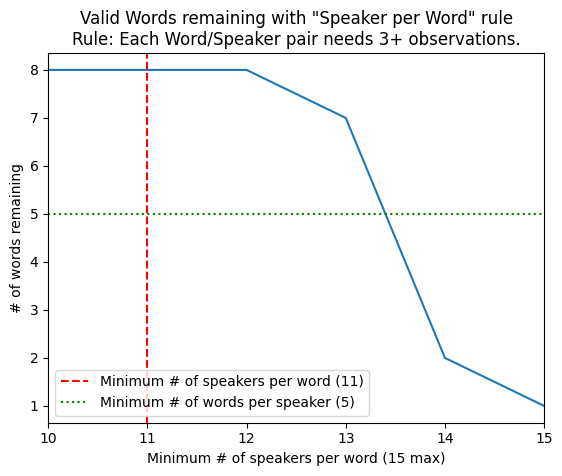

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1: Get the number of audio events per Speaker/Word in the data ('speech_id' identifies where a single speech event had multiple audio recordings.)
word_speaker_counts = df[['speaker_id','speech_id','transcription']].drop_duplicates().groupby(['speaker_id','transcription']).size().reset_index(name='count')

# 2: Which Speaker/Word combos have at least 3 Speech events? (these are the speech events we can sample from to make a personalization holdout.)
common_per_speaker = word_speaker_counts[word_speaker_counts['count'] >= 3]

# 3: Of this set, get Speakers per Word.
speaker_counts_per_word = common_per_speaker.groupby('transcription')['speaker_id'].nunique().reset_index(name='speaker_count')

# 4. If we set a requirement of "X speakers per word (with 3+ events)", how many words do we get to keep?
speaker_range = np.arange(10,16)
def valid_word_check(wordset, count):
  return len(wordset[wordset['speaker_count'] >= count])
wordcount = [valid_word_check(speaker_counts_per_word,x) for x in speaker_range]

# 5. Plot the tradeoffs with reasonable guidelines
minimum_speakers = 11
minimum_words = 5

# plot x=speaker_range and y=wordcount with a horizontal bar for 13.
sns.lineplot(x=speaker_range, y=wordcount)
plt.axvline(x=minimum_speakers, color='r', linestyle='--', label=f'Minimum # of speakers per word (11)')
plt.axhline(y=minimum_words, color='g', linestyle=':',label=f'Minimum # of words per speaker (5)')
plt.title('Valid Words remaining with "Speaker per Word" rule\nRule: Each Word/Speaker pair needs 3+ observations.')

plt.legend()
plt.xlabel('Minimum # of speakers per word (15 max)')
plt.ylabel('# of words remaining')
plt.xlim(10,15)
plt.savefig('valid_words.png')
plt.show()

### Evaluation

From this graph, If I'm willing to ignore the full-data problem for the participants I'm excluding (and therefore the ones I don't need to have 3+ in the first place), I'm able to keep eight of the words.

Question: If we allow for partial incompleteness, what speakers/words aren't fully covered?

In [ ]:
valid_threshold = 11
valid_words = speaker_counts_per_word[speaker_counts_per_word['speaker_count'] >= valid_threshold]
print(valid_words)

    transcription  speaker_count
1             air             14
51           knew             13
54           leak             12
62             no             13
89           sigh             13
92            sip             15
94           slip             13
117           yes             13


There's some good words here to work with in terms of phonetic overlap like knew/no and sip/slip, and theres also the yes/no pair, which is always good to handle for ASR tools.

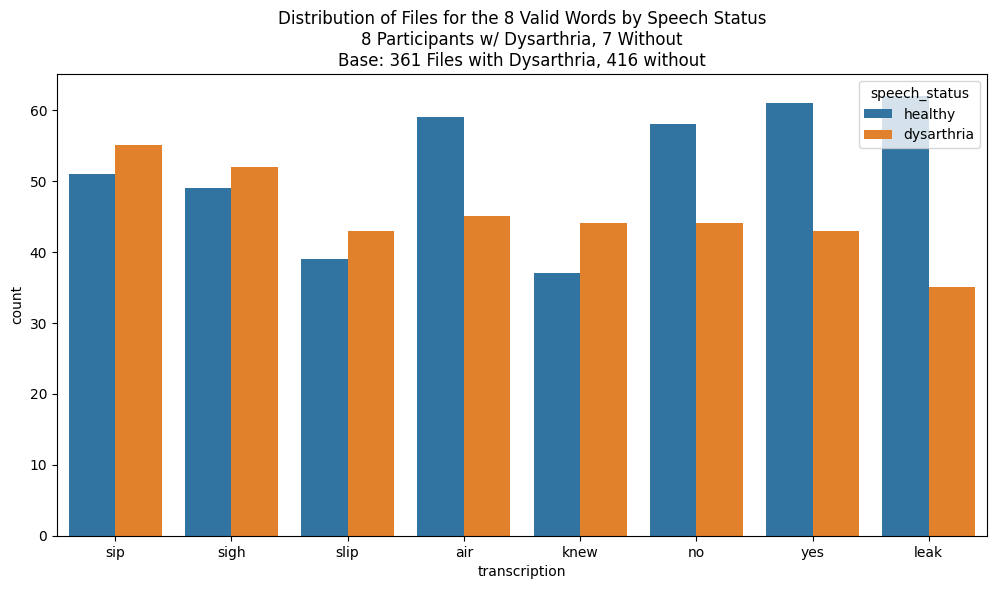

In [ ]:
# define our 'true dataset'
df_all = df[df['transcription'].isin(valid_words['transcription'])]

# how many files per group?
p_count_dys = df_all[df_all['speech_status']=='dysarthria']['speaker_id'].nunique()
p_count_heal = df_all[df_all['speech_status']=='healthy']['speaker_id'].nunique()
count_dys = len(df_all[df_all['speech_status']=='dysarthria'])
count_ndys = len(df_all[df_all['speech_status']=='healthy'])

plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='transcription', hue='speech_status')
plt.title(f"Distribution of Files for the 8 Valid Words by Speech Status\n{p_count_dys} Participants w/ Dysarthria, {p_count_heal} Without\nBase: {count_dys} Files with Dysarthria, {count_ndys} without")
plt.show()


## Holdout: Setup

We now want to set up the holout such that we can later build the triplets we'll be using for testing.

We want to do two things:

- Select a few participants in the data to hold out, so we can see how the trained model performs on someone not trained on.

- Select a few files in the data to hold out, so that a) the remaining data still has 2 files per speaker/word.

### Check: Which speakers are missing words?

We made the compromise that we have to accept that some words aren't spoken by all speakers enough. So, which speakers don't have enough?

In [ ]:
speaker_list = df_all['speaker_id'].unique()
word_list = df_all['transcription'].unique()

for speaker in df_all['speaker_id'].unique():
  df_speech_events = df_all[df_all['speaker_id']==speaker][['speaker_id','speech_id','transcription']].drop_duplicates()

  # for each word how many speech events are there
  se_count = [(word,len(df_speech_events[df_speech_events['transcription']==word])) for word in word_list if len(df_speech_events[df_speech_events['transcription']==word])<=2]

  if len(se_count)!=0:
    print(speaker,end="\n\t")
    for pair in se_count:
      print(f" {pair[0]} {pair[1]}",end=" ")
    print()

FC01
	 sigh 2  slip 2  knew 2  no 1  yes 2  leak 0 
M04
	 leak 0 
F01
	 sigh 0  slip 1  air 2  knew 2  no 1  yes 1  leak 0 


From this, it's clear that we need to exclude FC01, F01, and M04 from the training data. Thankfully, each of these are in a different split of the TORGO demographics (by gender and speech disorder status), so we can go ahead and just assign them to the list of speakers to exclude.

### Generalization Sampling

In [ ]:
## From earlier checks, we have to exclude these ones.
speaker_FA = "F01"
speaker_FnA = "FC01"
speaker_MA = 'M04'

# get a random healthy candidate.
candidates_MnA = df_all[(df_all['gender']!="female")&(df_all['speech_status']=="healthy")]['speaker_id'].drop_duplicates().values
speaker_MnA = random.sample(list(candidates_MnA),1)[0]

# now split df_all into the Gen-Holdout and the remaining data we need.
df_holdout_gen = df_all[df_all['speaker_id'].isin([speaker_FA,speaker_FnA,speaker_MA,speaker_MnA])]
df_all_remaining = df_all[~df_all['speaker_id'].isin([speaker_FA,speaker_FnA,speaker_MA,speaker_MnA])]

# check that the remaining data has the high level of speech events we want.
df_all_remaining_check = df_all_remaining[['speaker_id','gender','speech_status','transcription','speech_id']].drop_duplicates().groupby(['speaker_id','speech_status','gender','transcription']).size().reset_index(name='group_count')
# assert that each subset of the remainign data has balanced word representation by speech status.
assert df_all_remaining_check.groupby('speech_status')['transcription'].nunique().min()==8
assert df_all_remaining_check.groupby('speech_status')['transcription'].nunique().max()==8
# assert that each subset of the remainign data has balanced word representation by gender.
assert df_all_remaining_check.groupby('gender')['transcription'].nunique().min()==8
assert df_all_remaining_check.groupby('gender')['transcription'].nunique().max()==8
# asert that each word/speaker has enough speech events.
assert (df_all_remaining_check['group_count'] >= 3).all()

### Personalization Sampling

We know that there are at least 3 speech events per speaker/word remaining. So, our training set can be 2 speech events per speaker/word, and treat the remainder as holdout.

In [ ]:
# Find the speech_ids per speaker/word.
group_counts_per_word = df_all_remaining[['speaker_id','speech_status','transcription','speech_id']].drop_duplicates().groupby(['speaker_id','speech_status','transcription']).size().reset_index(name='group_count')

# How many of the Speaker/Word pairs can be sampled?
valid_groups = group_counts_per_word[group_counts_per_word['group_count'] >= 3]
print("Valid speaker/word pairs to holdout:\t",len(valid_groups),"/",len(group_counts_per_word))

Valid speaker/word pairs to holdout:	 88 / 88


All pairs can be handled. nice!

In [ ]:
# Get all Speaker/Word/Event options.
df_eligible = df_all_remaining[['speaker_id','transcription','speech_id']].drop_duplicates().copy().reset_index(drop=True)
df_eligible['id'] = df_eligible['speaker_id'] + df_eligible['speech_id']

# Sample two speech_id per group
df_sampled = df_eligible.groupby(['speaker_id', 'transcription'])['speech_id'].apply(lambda x: x.sample(2)).reset_index()
df_sampled['id'] = df_sampled['speaker_id'] + df_sampled['speech_id']

# Define the holdout set by excluding the sampled rows from df_eligible
df_unsampled = df_eligible[~df_eligible['id'].isin(df_sampled['id'])]

In [ ]:

print("Total sampled speaker/word/events:", df_sampled.shape)
print("Total holdout speaker/word/events:", df_unsampled.shape)

# Merge To df_all_remaining to get subset
df_train = df_sampled.merge(df_all_remaining, on=['speaker_id', 'transcription', 'speech_id'], how='left')
df_holdout_per = df_unsampled.merge(df_all_remaining, on=['speaker_id', 'transcription', 'speech_id'], how='left')

print(f"Original, # of Files:   {len(df_all_remaining)}")
print(f"     # Speech Events:   {len(df_eligible)}")

print(f"Training, # of Files:   {len(df_train)}")
print(f"     # Speech Events:   {len(df_sampled)}")

print(f"Holdout, # of Files:    {len(df_holdout_per)}")
print(f"     # Speech Events:   {len(df_unsampled)}")

Total sampled speaker/word/events: (176, 5)
Total holdout speaker/word/events: (161, 4)
Original, # of Files:   610
     # Speech Events:   337
Training, # of Files:   322
     # Speech Events:   176
Holdout, # of Files:    288
     # Speech Events:   161


In [ ]:
# try to set up df_unsampled in a nice way.
# do all speakers have all words?
df_unsampled.groupby('speaker_id')['transcription'].nunique().min()
# nice, they do! can we split every case?
print(df_unsampled.groupby(['speaker_id','transcription']).size().describe())

count    88.000000
mean      1.829545
std       0.899829
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       4.000000
dtype: float64


In [ ]:
# Merge the two dataframes on all three keys
df_overlap = df_sampled.merge(df_unsampled, on=['speaker_id', 'transcription', 'speech_id'], how='inner')
print(f"Number of overlapping rows: {len(df_overlap)}")

Number of overlapping rows: 0


## Triplet Construction

In [ ]:
def safe_sample(df, group_cols=None):
    try:
        if group_cols:
            return df.groupby(group_cols).sample(1)['path'].sample(1).values[0]
        return df['path'].sample(1).values[0]
    except Exception as e:
        print(f"Failed to sample: {e}")
        return None

def get_type4_pair(df_all, word, speaker, status, same_status=True,debug=False):
    # for a type 4 triplet, sample a random speaker, then get positive and negatives.
    status_filter = status if same_status else (lambda x: x != status)
    df = df_all[(df_all['transcription'] == word) &
                (df_all['speaker_id'] != speaker) &
                (df_all['speech_status'] == status if same_status else df_all['speech_status'] != status)]
    if debug:
        print(f"df size for word '{word}', speaker '{speaker}', status '{status}': {len(df)}")
    if df.empty:
      print(f"df size for word '{word}', speaker '{speaker}', status '{status}': {len(df)}")
      return None, None

    speaker_b = df['speaker_id'].drop_duplicates().sample(1).values[0]
    if debug:
        print(f"speaker_b: {speaker_b}")

    df_pos = df_all[(df_all['transcription'] == word) & (df_all['speaker_id'] == speaker_b)]
    df_neg = df_all[(df_all['transcription'] != word) & (df_all['speaker_id'] == speaker_b)]

    positive = safe_sample(df_pos)
    negative = safe_sample(df_neg, 'transcription')
    return positive, negative

triplets = []
# set seed.
random.seed(101)

print(f"Expected number of triplets: {14*len(df_train.groupby(['speaker_id', 'speech_status', 'transcription']))}")
for (speaker, status, word), group in df_train.groupby(['speaker_id', 'speech_status', 'transcription']):
  speech_ids = group['speech_id'].drop_duplicates().tolist()
  if len(speech_ids) < 2:
    print("SKIP")
    continue  # skip if not enough speech_ids for positive pair
  sampled_speech_ids = random.sample(speech_ids, 2)
  if len(sampled_speech_ids)!=2:
    print("SKIP")
    print(speaker, status, word)
    continue
  #print(len(triplets))
  for sid in sampled_speech_ids:
    anchor = df_train[(df_train['speaker_id'] == speaker) & (df_train['speech_id'] == sid)]['path'].sample(1).values[0]
    sid_alt = [x for x in sampled_speech_ids if x!=sid][0]
    positive_same = df_train[(df_train['speaker_id'] == speaker) & (df_train['speech_id'] == sid_alt)]['path'].sample(1).values[0]

    # Type 1s (A "go", A "go, Bs "go")
    df_1s = df_train[(df_train['transcription'] == word) & (df_train['speaker_id'] != speaker) & (df_train['speech_status'] == status)]
    negative_1s = safe_sample(df_1s, 'speaker_id')
    if negative_1s:
        triplets.append({'anchor': anchor, 'positive': positive_same, 'negative': negative_1s, 'triplet_type': '1s', 'anchor_status':status})
    else:
      print(f"anchor:{anchor},positive_same:{positive_same},len_df_1s:{len(df_1s)}")

    # Type 1s (A "go", A "go" , Bd "go")
    df_1d = df_train[(df_train['transcription'] == word) & (df_train['speaker_id'] != speaker) & (df_train['speech_status'] != status)]
    negative_1d = safe_sample(df_1d, 'speaker_id')
    if negative_1d:
        triplets.append({'anchor': anchor, 'positive': positive_same, 'negative': negative_1d, 'triplet_type': '1d', 'anchor_status':status})
    else:
      print(f"anchor:{anchor},positive_same:{positive_same},len_df_1d:{len(df_1d)}")

    # Type 2  (A "go", A "go", A "stop")
    df_2 = df_train[(df_train['transcription'] != word) & (df_train['speaker_id'] == speaker)]
    negative_2 = safe_sample(df_2, 'transcription')
    if negative_2:
        triplets.append({'anchor': anchor, 'positive': positive_same, 'negative': negative_2, 'triplet_type': '2', 'anchor_status':status})
    else:
        print(f"anchor:{anchor},positive_same:{positive_same},len_df_2:{len(df_2)}")

    # Type 3 shared negative
    df_3n = df_train[(df_train['transcription'] != word) & (df_train['speaker_id'] == speaker)]
    negative_3 = safe_sample(df_3n, 'transcription')

    # Type 3s (A "go", Bs "go", A "stop")
    df_3s = df_train[(df_train['transcription'] == word) & (df_train['speaker_id'] != speaker) & (df_train['speech_status'] == status)]
    positive_3s = safe_sample(df_3s, 'speaker_id')
    if positive_3s and negative_3:
        triplets.append({'anchor': anchor, 'positive': positive_3s, 'negative': negative_3, 'triplet_type': '3s', 'anchor_status':status})
    else:
        print(f"anchor:{anchor},len_df_3n:{len(df_3n)},len_df_3s:{len(df_3s)}")

    # Type 3d (A "go", Bd "go", A "stop")
    df_3d = df_train[(df_train['transcription'] == word) & (df_train['speaker_id'] != speaker) & (df_train['speech_status'] != status)]
    positive_3d = safe_sample(df_3d, 'speaker_id')
    if positive_3d and negative_3:
        triplets.append({'anchor': anchor, 'positive': positive_3d, 'negative': negative_3, 'triplet_type': '3d', 'anchor_status':status})
    else:
        print(f"anchor:{anchor},len_df_3n:{len(df_3n)},len_df_3d:{len(df_3d)}")

    # Type 4s (A "go", Bs "go", Bs "stop")
    pos_4s, neg_4s = get_type4_pair(df_train, word, speaker, status, same_status=True)
    if pos_4s and neg_4s:
        triplets.append({'anchor': anchor, 'positive': pos_4s, 'negative': neg_4s, 'triplet_type': '4s', 'anchor_status':status})
    else:
        print(speaker, status, word)

    # Type 4s (A "go", Bd "go", Bd "stop")
    pos_4d, neg_4d = get_type4_pair(df_train, word, speaker, status, same_status=False)
    if pos_4d and neg_4d:
      triplets.append({'anchor': anchor, 'positive': pos_4d, 'negative': neg_4d, 'triplet_type': '4d', 'anchor_status':status})
    else:
      print(speaker, status, word)

Expected number of triplets: 1232


In [ ]:
# Set up as a dataframe.
triplet_df = pd.DataFrame(triplets)
print(triplet_df.shape)

# define a few things
triplet_df['anchor_user_id'] = triplet_df['anchor'].str.split('_').str[0]
triplet_df['anchor_gender'] = triplet_df['anchor_user_id'].str[0]
triplet_df['pos_user_id'] = triplet_df['positive'].str.split('_').str[0]
triplet_df['pos_gender'] = triplet_df['pos_user_id'].str[0]
triplet_df['neg_user_id'] = triplet_df['negative'].str.split('_').str[0]
triplet_df['neg_gender'] = triplet_df['neg_user_id'].str[0]
triplet_df['pos_status'] = ["healthy" if x[1]=="C" else "dysarthria" for x in triplet_df['positive']]
triplet_df['neg_status'] = ["healthy" if x[1]=="C" else "dysarthria" for x in triplet_df['negative']]
triplet_df.head()


(1232, 5)


,anchor,positive,negative,triplet_type,anchor_status,anchor_user_id,anchor_gender,pos_user_id,pos_gender,neg_user_id,neg_gender,pos_status,neg_status
0,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,M02_1_arrayMic_0104.wav,1s,dysarthria,F03,F,F03,F,M02,M,dysarthria,dysarthria
1,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,MC04_1_headMic_0624.wav,1d,dysarthria,F03,F,F03,F,MC04,M,dysarthria,healthy
2,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,F03_1_headMic_0164.wav,2,dysarthria,F03,F,F03,F,F03,F,dysarthria,dysarthria
3,F03_1_arrayMic_0201.wav,M03_2_arrayMic_0010.wav,F03_1_headMic_0099.wav,3s,dysarthria,F03,F,M03,M,F03,F,dysarthria,dysarthria
4,F03_1_arrayMic_0201.wav,FC02_2_arrayMic_0092.wav,F03_1_headMic_0099.wav,3d,dysarthria,F03,F,FC02,F,F03,F,healthy,dysarthria


In [ ]:
# Check distribution of gender in the triplets
gender_balance = triplet_df['anchor_gender'].value_counts()
print("Anchor gender balance in triplets:")
print(gender_balance)

# Check distribution of gender in the triplets
gender_balance = triplet_df['pos_gender'].value_counts()
print("Positive gender balance in triplets:")
print(gender_balance)

# Check distribution of gender in the triplets
gender_balance = triplet_df['neg_gender'].value_counts()
print("Negative gender balance in triplets:")
print(gender_balance)


Anchor gender balance in triplets:
anchor_gender
M    784
F    448
Name: count, dtype: int64
Positive gender balance in triplets:
pos_gender
M    771
F    461
Name: count, dtype: int64
Negative gender balance in triplets:
neg_gender
M    772
F    460
Name: count, dtype: int64


In [ ]:
# check gender balence?
# for anchor_user_id, pos_user_id, neg_user_id, get value counts and combine into one table
df_anchor = triplet_df['anchor_gender'].value_counts().reset_index(name='anchor').sort_values('anchor',ascending=False)
df_anchor = df_anchor.rename(columns={'anchor_gender':'gender'})
df_pos = triplet_df['pos_gender'].value_counts().reset_index(name='positive').sort_values('positive',ascending=False)
df_pos = df_pos.rename(columns={'pos_gender': 'gender'})
df_neg = triplet_df['neg_gender'].value_counts().reset_index(name='negative').sort_values('negative',ascending=False)
df_neg = df_neg.rename(columns={'neg_gender': 'gender'})
df_anchor.merge(df_pos, on='gender', how='outer').merge(df_neg, on='gender', how='outer')

,gender,anchor,positive,negative
0,F,448,461,460
1,M,784,771,772


In [ ]:
# check speaker balence?
# for anchor_user_id, pos_user_id, neg_user_id, get value counts and combine into one table
df_anchor = triplet_df['anchor_user_id'].value_counts().reset_index(name='anchor').sort_values('anchor',ascending=False)
df_anchor = df_anchor.rename(columns={'anchor_user_id':'user_id'})
df_pos = triplet_df['pos_user_id'].value_counts().reset_index(name='positive').sort_values('positive',ascending=False)
df_pos = df_pos.rename(columns={'pos_user_id': 'user_id'})
df_neg = triplet_df['neg_user_id'].value_counts().reset_index(name='negative').sort_values('negative',ascending=False)
df_neg = df_neg.rename(columns={'neg_user_id': 'user_id'})
df_anchor.merge(df_pos, on='user_id', how='outer').merge(df_neg, on='user_id', how='outer')

,user_id,anchor,positive,negative
0,F03,112,114,110
1,F04,112,112,111
2,FC02,112,120,118
3,FC03,112,115,121
4,M01,112,103,106
5,M02,112,96,115
6,M03,112,105,99
7,M05,112,110,99
8,MC02,112,111,114
9,MC03,112,127,128


## Store Metadata + Triplets

In [ ]:
df_triplets = triplet_df.copy()
df_triplets.head()
df_triplets[['anchor','positive','negative','triplet_type',
             'anchor_status','anchor_user_id','anchor_gender',
             'pos_status','pos_user_id','pos_gender',
             'neg_status','neg_user_id','neg_gender']].to_csv(
                 "/content/drive/MyDrive/torgo_data/triplet_data.csv", index=False)

In [ ]:
df_holdout_gen[['path','speaker_id','gender','speech_status','transcription','speech_id']].to_csv(
    "/content/drive/MyDrive/torgo_data/holdout_gen.csv", index=False)

df_holdout_per[['path','speaker_id','gender','speech_status','transcription','speech_id']].to_csv(
    "/content/drive/MyDrive/torgo_data/holdout_per.csv", index=False)

df_train[['path','speaker_id','gender','speech_status','transcription','speech_id']].to_csv(
    "/content/drive/MyDrive/torgo_data/train_data.csv", index=False)

## Epilogue: Slice parquet

Earlier, I loaded the parquet without the array, because I didn't need it. To make things easier, let's load it now, and slice it using the data available.

In [ ]:
# load parquet again with the arrays we need.
my_audio_data = Dataset.from_parquet("/content/drive/MyDrive/torgo_data/torgo_subset.parquet")

my_audio_data[0]

Generating train split: 0 examples [00:00, ? examples/s]

{'audio': {'path': 'FC01_1_arrayMic_0066.wav',
  'array': array([ 0.00125122,  0.00387573,  0.00115967, ...,  0.00149536,
         -0.00326538,  0.00027466]),
  'sampling_rate': 16000},
 'transcription': 'alpha',
 'speech_status': 'healthy',
 'gender': 'female',
 'duration': 3.3}

We need to keep files that are in any of the three datasets (df_train, df_holdout_gen, df_holdout_per). So let's build that.

In [ ]:
paths_df_train = set(df_train['path'].unique())
paths_df_holdout_gen = set(df_holdout_gen['path'].unique())
paths_df_holdout_per = set(df_holdout_per['path'].unique())

# check there's no overlap. There really shouldnt be.
assert len(paths_df_train.intersection(paths_df_holdout_gen))==0
assert len(paths_df_train.intersection(paths_df_holdout_per))==0

paths_to_keep = paths_df_train.union(paths_df_holdout_gen).union(paths_df_holdout_per)

assert None not in paths_to_keep

Now filter:

In [ ]:
def filter_by_path(example, pathset):
    return example['audio']['path'] in paths_to_keep

# Filter the dataset
my_audio_data = my_audio_data.filter(lambda x: x['audio']['path'] is not None)
filtered_audio_data = my_audio_data.filter(filter_by_path,paths_to_keep)

# Check the result
print(f"Original dataset size: {len(my_audio_data)}")
print(f"Filtered dataset size: {len(filtered_audio_data)}")

Filter:   0%|          | 0/16552 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16552 [00:00<?, ? examples/s]

Original dataset size: 16552
Filtered dataset size: 776


And save!

In [ ]:
# flatten the filtered dataset to prevent storage issues

def flatten_audio(example):
  example['audio_array'] = example['audio']['array']
  example['sampling_rate'] = example['audio']['sampling_rate']
  example['audio_path'] = example['audio']['path']
  example['audio_array_length'] = len(example['audio']['array'])
  del example['audio']
  return example

flat_audio_data = filtered_audio_data.map(flatten_audio)
flat_audio_data.to_parquet("/content/drive/MyDrive/torgo_data/flat_torgo.parquet")

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

229778603